In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm

In [2]:
class Particle:
    
    def __init__(self, r0, v0, a0, t, m=1, radius=2., Id=0):
        
        self.dt = t[1] - t[0]
        
        
        # Atributos instantaneos
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
        
        self.p = self.m*self.v
        self.l = np.cross(self.r,self.p)
        self.f = self.m*self.a
        self.ek = 0.5*self.m*np.dot(self.v,self.v)
        self.eu = 0.
        
        # Historial
        
        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)
        
        self.F = np.zeros_like(self.R)
        
        self.P = np.zeros_like(self.R)
    
        # Fisica
        self.K = 20.
        
        self.Ek = np.zeros(len(t))
        self.Eu = np.zeros_like(self.Ek)
        self.L = np.zeros_like(self.Ek)
        
    def Evolution(self,i):
        
        self.SetPosition(i)
        self.SetVelocity(i)
        self.SetMomentum(i)
        self.SetAngularMomentum(i)
        self.SetKineticEnergy(i)
        self.SetPotentialEnergy(i)
        
        self.a = self.f/self.m

        
        # Euler
        #self.r += self.dt*self.v
        #self.v += self.dt*self.a
        
        # Euler-Cromer
        self.v += self.dt*self.a
        self.r += self.dt*self.v
        
        self.p = self.m*self.v
        self.l = np.cross(self.r,self.p)
        self.ek = 0.5*self.m*np.dot(self.v,self.v)
        
    def CalculateForce(self,p,it):
        
        d = np.linalg.norm(self.r - p.r)
        
        compresion = self.radius + p.radius - d
        
        if compresion >= 0:
            
            Fn = self.K * compresion**3
            
            self.n = (self.r - p.r)/d     
            self.f = np.add(self.f,Fn*self.n)
            
            # Falta implementar energía potencial 
            
            self.eu += np.add(self.Eu[it], (1/4)*self.K*compresion**4)
            
     
    # Aca debes agregar la energía potencial
    def ResetForce(self):
        self.f[:] = 0.
        self.a[:] = 0.
        self.eu = 0.
    
    # Setter
    def SetPosition(self,i):
        self.R[i] = self.r
    
    def SetVelocity(self,i):
        self.V[i] = self.v
        
    def SetMomentum(self,i):
        self.P[i] = self.p
        
    def SetAngularMomentum(self,i):
        self.L[i] = self.l
        
    def SetKineticEnergy(self,i):
        self.Ek[i] = self.ek
        
    def SetPotentialEnergy(self,i):
        self.Eu[i] = self.eu
    
    # Getter
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
 
    def GetMomentum(self,scale=1):
        return self.P[::scale]
    
    def GetAngularMomentum(self,scale=1):
        return self.L[::scale]
    
    def GetKineticEnergy(self,scale=1):
        return self.Ek[::scale]
    
    def GetPotentialEnergy(self,scale=1):
        return self.Eu[::scale]
    
    # Debes agregar las paredes en este punto
    
    def CheckLimits(self):
        
        Limits = np.array([[-20.,20.],[-20.,20.]])
        
        for i in range(2):
        
            if self.r[i] + self.radius > Limits[i][1] and self.v[i] > 0.:
                self.v[i] = -1.0*self.v[i]
            if self.r[i] - self.radius < Limits[i][0] and self.v[i] < 0.:
                self.v[i] = -1.0*self.v[i]

En el códgo de arriba, se utilizó el hecho de que la energía potencial correspondiente a la fuerza $F(\vec{r}, \theta) = k|\vec{r}|^3\hat{r}$ es $E(\vec{r}, \theta) = \frac{k|\vec{r}|^4}{4}$. A continuación, se muestra este hecho formalmente.

Antes de continuar, vale la pena aclarar que definimos la fuerza $F$ en un sistema donde existe una partícula cuyo centro se encuentra en el punto (0,0), y la fuerza $F$ representa la fuerza que siente una segunda partícula cuyo centro está dado por las coordenadas (r, \theta). Esto implica que la nuestra fuerza sólo estará definida en un círculo de radio 4 (la suma de los radios de ambas partículas) alrededor del orígen, pues más allá de este punto la fuerza de restauración debe ser 0.

En primer lugar, es necesario mostrar que $F$ es conservativa. En otras palabras:

$$
\oint\, F(x)\, dx = 0
$$

Note que $F$ está definida en una región simplemente conexa, por lo que el teorema de Green indica que: 

$$
\oint\, F(x)\, dx = \int\int \triangledown \times F dA
$$

Teniendo esto en cuenta, mostramos que $\triangledown \times F = 0$. Para esto, primero escribimos la fuerza F en coordenadas cartesianas.

$$
F(\vec{r}, \theta) = k|\vec{r}|^3\hat{r}
\rightarrow
F(x, y) = k(\sqrt{x^2+y^2})^3\frac{x\hat{i}+y\hat{j}}{(x^2+y^2)^{\frac{1}{2}}}
$$

$$
F(x,y) = k(x^2+y^2)(x\hat{i}+y\hat{j})
\rightarrow
F(x,y) = (k(x^2+y^2)x,k(x^2+y^2)y)
$$

De aquí es fácil verificar que:

$$
\triangledown \times F = \frac{\partial}{\partial x}(k(x^2+y^2)y) - \frac{\partial}{\partial y}(k(x^2+y^2)x) = k(2xy) - k(2xy) = 0.
$$

Por tanto, la fuerza $F$ es conservativa.

Para encontrar la energía potencial correspondiente, basta con encontrar una función (potencial) $E$ tal que 

$$
\frac{\partial E}{\partial x} = k(x^2+y^2)x
$$

$$
\frac{\partial E}{\partial y} = k(x^2+y^2)y
$$

Para esto, se resolvemos la siguiente ecuación diferencial:

$$
dE(x,y) = k(x^2+y^2)xdx + k(x^2+y^2)ydy
$$

$$
E(x,y) = k(\frac{x^4}{4}+\frac{x^2y^2}{2}) + g(y) 
$$

$$
k(x^2+y^2)y = k(x^2y) + g'(y)
\rightarrow
g(y) = \frac{ky^4}{4}
$$

Así pues, concluímos:

$$
E(x,y) = k(\frac{x^4}{4}+\frac{x^2y^2}{2}) + \frac{ky^4}{4} = \frac{k}{4}(x^2+y^2)^2 = \frac{k}{4}(|\vec{r}|)^4
$$

Como queríamos.

In [3]:
def GetParticles(N,t):

    Particles = [0]*N

    for i in range(N):
        r0 = np.array([np.random.uniform(-20,20),np.random.uniform(-20,20)])
        v0 = np.array([np.random.uniform(-5,5),np.random.uniform(-5,5)])
        a0 = np.array([0.,0.])
        p = Particle(r0,v0,a0,t,m=1,radius=2,Id=i)
        Particles[i] = p
    
    # Aca deber agregar una rutina montecarlo para crear particulas
    # sobre el plano con velocidades aleatorias.
    
    return Particles

In [4]:
dt = 0.001
tmax = 10
t = np.arange(0,tmax,dt)
Particles = GetParticles(10,t)

In [5]:
def RunSimulation(t,Particles):
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        
        for i in range(len(Particles)):
            for j in range(len(Particles)):
                if i!=j:
                    Particles[i].CalculateForce(Particles[j], it)
        
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            
            # Aca debes agregar la interaccion con la pared
            
            #Particles[i].CheckLimits()
            
            
    return Particles

In [6]:
Particles = RunSimulation(t,Particles)

Running simulation: 100%|██████████| 10000/10000 [00:12<00:00, 782.11 Steps/s]


In [7]:
# Bajamos dimensión de la simulacion
scale = 200
t1 = t[::scale]

<IPython.core.display.Javascript object>


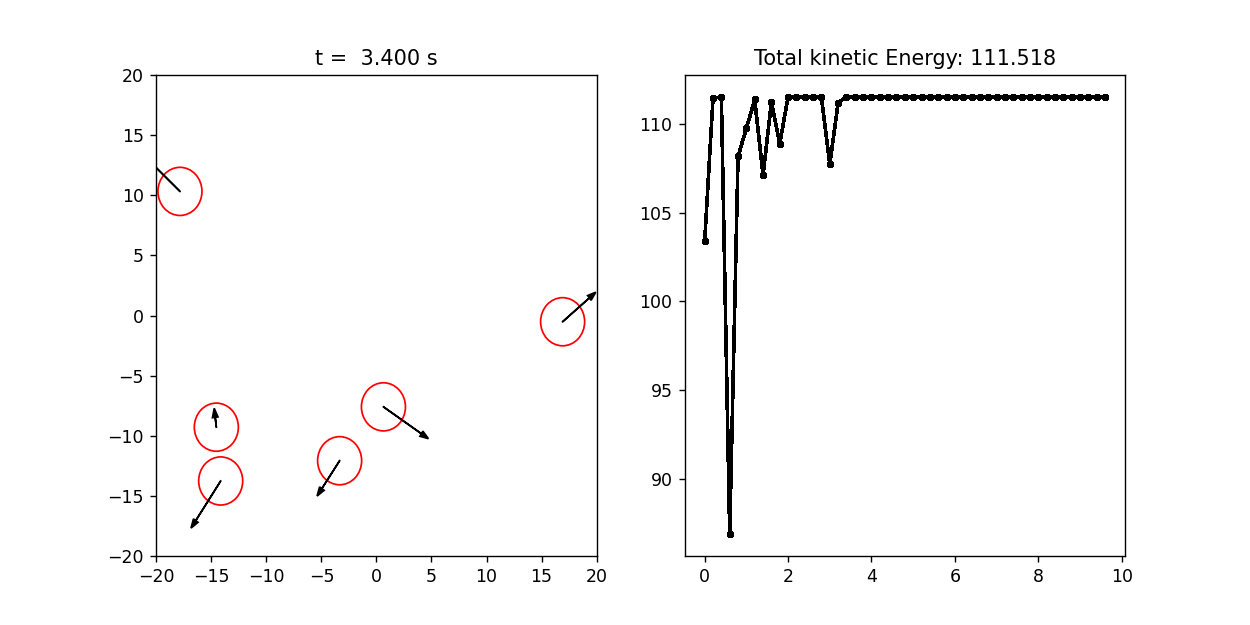

In [8]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
KEtotal = np.zeros(len(t1))

def init():
    
    ax.clear()
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    
def Update(i):
    
    init()
    ax.set_title(r't =  %.3f s' %(t1[i]))
    
    
    # Queremos calcular la energía total de cinética
    KEcurrent = 0. # Kinetic energy
    KUcurrent = 0. # Potential energy
    
    for p in Particles:
        
        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]
        
        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]
        
        circle = plt.Circle( (x,y), p.radius, color='r', fill=False )
        ax.add_patch(circle)
        
        ax.arrow(x,y,vx,vy,color='k',head_width=0.5,length_includes_head=True)
        
        KEcurrent += p.GetKineticEnergy(scale)[i]
        
    KEtotal[i] = KEcurrent
        
    ax1.set_title(r'Total kinetic Energy: {:.3f}'.format(KEcurrent))
    ax1.plot(t1[:i], KEtotal[:i],color='k',marker='.')
        
Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)

La figura de arriba muestra que la energía cinética máxima (la que se aprecia cuando no hay colisiones) se mantiene prácticamente constante a lo largo del experimento. Es claro que en momentos donde hay colisiones, esta energía se transforma en energía potencial, pero cuando estas terminan se puede ver que la energía cinética vuelve al mismo punto. Físicamente, se están intentando modelar colisiones elásticas y, como no hay un agente externo que le provea energía al sistema, la energía cinética se debería conservar después de que ocurran las colisiones. De esta manera vemos que la simulación concuerda en gran medida con la realidad.

In [9]:
MomentumT = Particles[0].GetMomentum(scale)

In [10]:
for i in range(1,len(Particles)):
    MomentumT = np.add(MomentumT,Particles[i].GetMomentum(scale))

In [11]:
AngularMomentumT = Particles[0].GetAngularMomentum(scale)

In [12]:
for i in range(1,len(Particles)):
    AngularMomentumT = np.add(AngularMomentumT,Particles[i].GetAngularMomentum(scale))

<IPython.core.display.Javascript object>


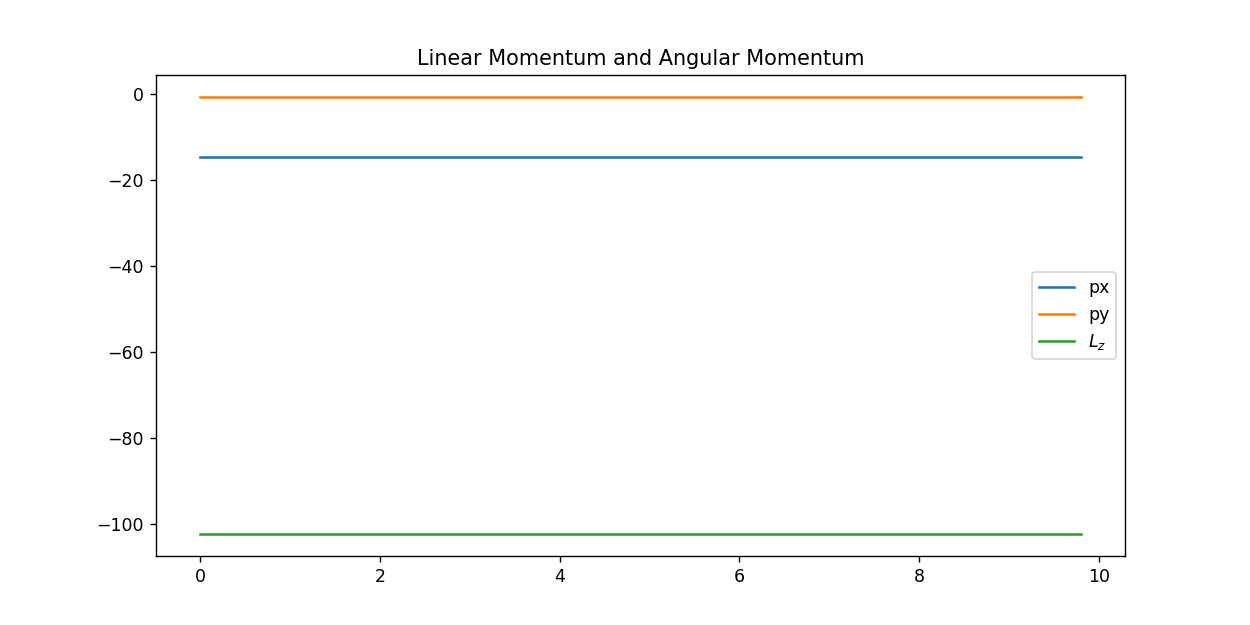

In [13]:
fig3 = plt.figure(figsize=(10,5))
ax2 = fig3.add_subplot(111)
ax2.plot(t1,MomentumT[:,0],label='px')
ax2.plot(t1,MomentumT[:,1],label='py')
ax2.plot(t1, AngularMomentumT,label=r'$L_z$')
ax2.set_title("Linear Momentum and Angular Momentum")
ax2.legend()

La gráfica de arriba muestra que el momento lineal (tanto en x como en y) y el momento angular con respecto al ej z del plano se conservan a lo largo de la simulación. Esto cumple las leyes de conservación puesto que no hay ningún agente externo al sistema (entendiendo al sistema como las 10 partículas juntas), que le proporcione o le sustraya momento lineal o angular. Es decir, la simulación está de acuerdo con los esperado físicamente.

Lo anterior indica que, en caso de que el sistema se extendiera a 3D, las partículas mantendrían el mismo plano de movimiento, en lugar de extenderse por todo el volumen; puesto que, de lo contrario, no se conservaría el momento angular. A nivel de código, también se puede entender que, como a las partículas no se les provee nunca una velocidad inicial en z, estas no podrían salir del plano z=0.

In [14]:
EnergyK = Particles[0].GetKineticEnergy(scale)

EnergyP = Particles[0].GetPotentialEnergy(scale)

In [15]:
for i in range(1,len(Particles)):
    MomentumT = np.add(MomentumT,Particles[i].GetMomentum(scale))
    EnergyK = np.add(EnergyK,Particles[i].GetKineticEnergy(scale))
    EnergyP = np.add(EnergyP,Particles[i].GetPotentialEnergy(scale))

In [16]:
EnergyP *= 0.5

<IPython.core.display.Javascript object>


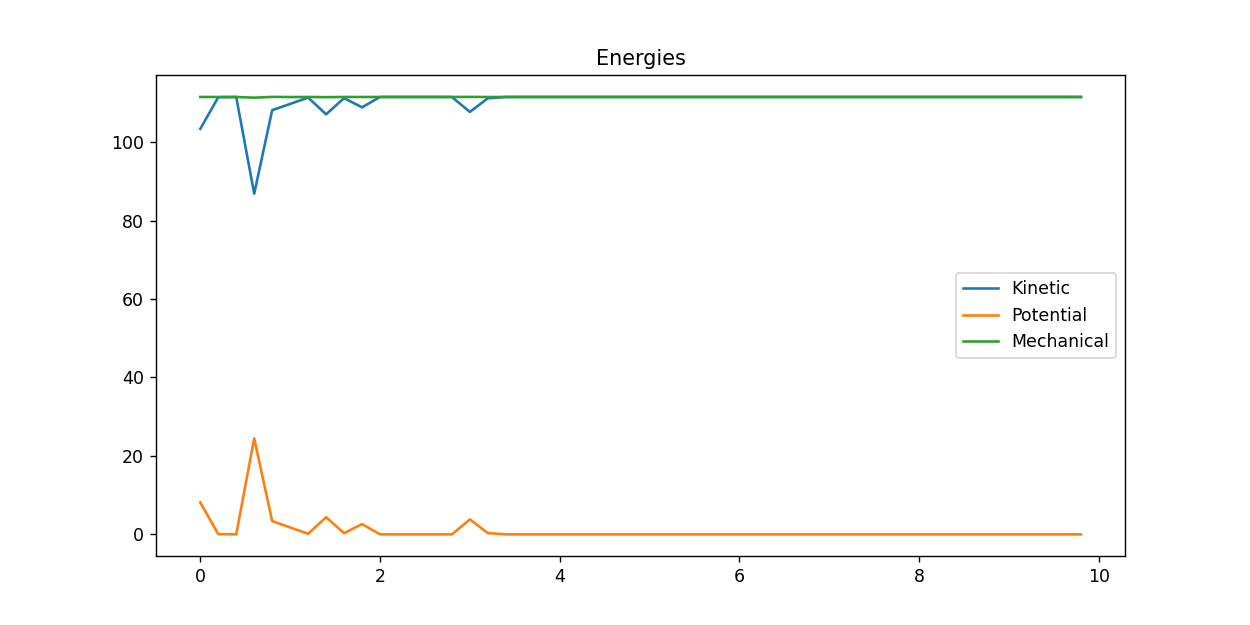

In [17]:
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(111)
ax3.plot(t1,EnergyK,label='Kinetic')
ax3.plot(t1,EnergyP,label='Potential')
ax3.plot(t1,EnergyK+EnergyP,label='Mechanical')
ax3.set_title("Energies")
ax3.legend()

En la gráfica de arriba se encuentran la energía cinética, potencial y mecánica (cinética + potencial) totales a lo largo de la simulación. En primer lugar, note que la energía potencial es 0 o positiva (cuando ocurren colisiones) en todo moomento. Es decir, nunca es negativa. Esto implica que el sistema presentado no es un sistema ligado. Adicionalmente, la energía mecánica es casi constante, salvo algunas fluctuaciones mínimas, del orden del $10^{-1}$, que no deberían suceder en condiciones ideales (se pueden apreciar en la gráfica de abajo). Esto puede deberse a que si bien el método de Euler-Cromer es mucho más estable que el método de Euler, este aún puede tener problemas al calcular la energía cuando ocurren varias colisiones simultáneamente.  Así pues, si obviamos estas fluctuaciones, se puede afirmar que se está cumpliendo el teorema del trabajo y la energía en esta simulación.

<IPython.core.display.Javascript object>


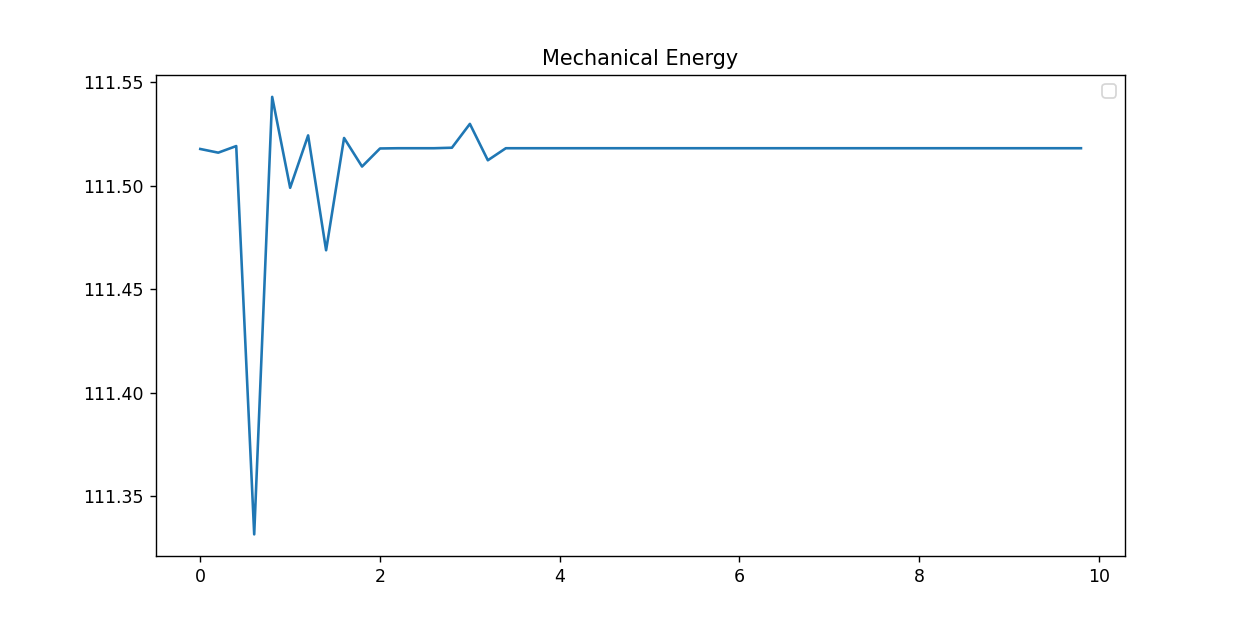

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [18]:
fig4 = plt.figure(figsize=(10,5))
ax4 = fig4.add_subplot(111)
ax4.plot(t1,EnergyK+EnergyP)
ax4.set_title("Mechanical Energy")
ax4.legend()